In [1]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from plotting import run_plotter as rp
from plotting import histogram as hist

In [2]:
reload(dl)
RUN = [1]

rundata_numu, mc_weights_numu, data_pot_numu = dl.load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    numupresel=True,
    loadnumuvariables=True
)

/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
reload(hist)
reload(rp)

selection = "NUMU"
preselection = "NUMU"

plotter_numu = rp.Plotter(rundata_numu, selection, preselection, variable="neutrino_energy", data_pot=data_pot_numu)

<AxesSubplot:title={'center':'$\\nu_{\\mu}$ selection and $\\nu_{\\mu}$ selection'}, xlabel='neutrino reconstructed energy [GeV]', ylabel='Events'>

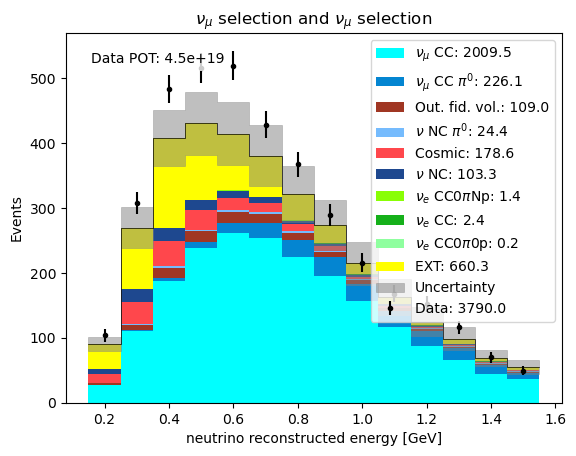

In [4]:
plotter_numu.plot(category_column="category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None)

In [5]:
reload(dl)
RUN = [1]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=["nue"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
)

../../data_loading.py:1023: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1023: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:542: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:542: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:705: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, 

Loading lee sample


In [7]:
reload(hist)
reload(rp)

selection = "NPL"
preselection = "NP"

plotter = rp.Plotter(rundata, selection, preselection, variable="reco_e", data_pot=data_pot, sideband_generator=plotter_numu)

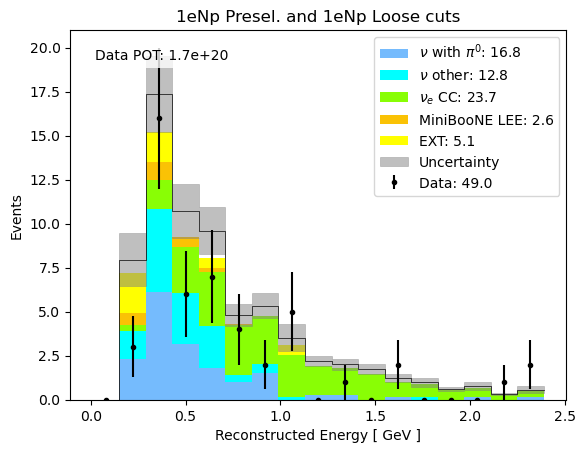

In [8]:
ax = plotter.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=True)

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp Loose cuts'}, xlabel='Reconstructed Energy [ GeV ]', ylabel='Events'>

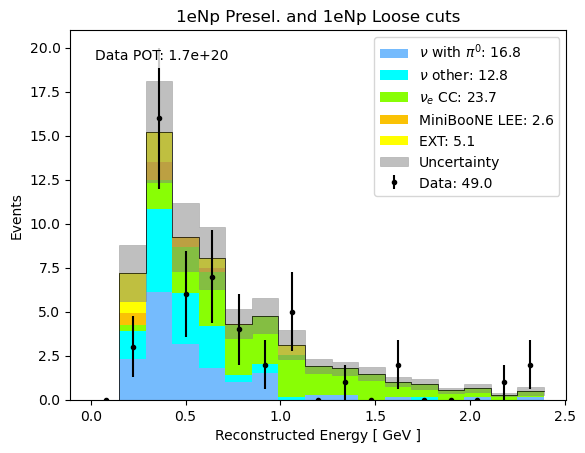

In [9]:
plotter.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=False)